In [1]:
%load_ext autoreload
%autoreload 2
import feature_extract
import sys
sys.path.append("..")
import torch
import psql_methods as psql
import pickle
import alchemy_methods as alc
from tqdm import tqdm
import numpy as np
import image_utils as imgs
import Openseas_Methods as opse
import multiprocessing
import pandas as pd
import feature_utils as feat
import matplotlib.pyplot as plt
import counterfeit_utils as cfu

In [ ]:
f = open('top_100_slugs.txt','r')
slugs = list(f)
slugs = [x.strip('\n') for x in slugs]
commands = ["SELECT slug from nfttoimage group by slug having count(*)<>600"]
data = psql.execute_commands(commands)
data = [x[0] for x in data]
print(len(data))
#Figure out which labels still need to find URLs for
nfts_to_process = [x for x in slugs if x not in data]
nfts_to_process = [x for x in nfts_to_process if x not in opse.SKIP_LIST]
nfts_to_process

In [ ]:
import logging
logging.basicConfig(filename='counterfeit_url_logs.txt', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
for slug in tqdm(nfts_to_process):
    logging.info(f"Beginning slug {slug}")
    data.append(opse.pull_nft_images(slug,limit_toks=10000))
    logging.info(f"Finished slug {slug}")

In [ ]:
#Pull 500 images per NFT collectino 
tup_slugs = tuple(slugs)
command = [f"""WITH numbered_rows AS (
  SELECT *,
         ROW_NUMBER() OVER (PARTITION BY slug ORDER BY RANDOM()) AS row_num
  FROM nfttoimage
  where slug in {tup_slugs}
)
SELECT *
FROM numbered_rows
WHERE row_num <= 500;"""]
rows  = psql.execute_commands(command)

In [ ]:
rows = [(x[0],x[1],x[2]) for x in rows]
args = imgs.db_to_args(rows)

In [ ]:
records = []
num_processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=num_processes) as pool: # Use all cores   
    for result in pool.starmap(imgs.pull_image_from_url, args):
        records.append(result)

In [ ]:
imgs.delete_empty_directories('counterfeit_images')

In [2]:
#We can now create a dataframe with th embeddings of all of th top 100 NFTs
#We assume the features have already been computed by the feature_extract_notebook
model_string = 'dinov2_vits14'
data_path = '/global/scratch/tlundy/NFT_Research/nft_research/Dino/counterfeit_images'
out_path = f'/global/scratch/tlundy/NFT_Research/nft_research/Dino/counterfeit_features/{model_string}'
feature_path = out_path+'/testfeat.pth'
features = torch.load(feature_path)
labels = feature_extract.get_labels(data_path)
file_names = feature_extract.get_filenames(data_path)
features_list = features.tolist()
# Create a pandas DataFrame
data = {'Label': labels.tolist(), 'Features': features_list,'Collection':[x[0] for x in file_names],
        'NFT_num':[x[1] for x in file_names]}
df = pd.DataFrame(data)
del features
del features_list
del data


Dataset ReturnIndexDataset
    Number of datapoints: 60382
    Root location: /global/scratch/tlundy/NFT_Research/nft_research/Dino/counterfeit_images/val


In [3]:
#Next we load the dataframe containing embeddings of all other collection
df2 = pd.read_pickle('graph_images_dataframe.pkl')
df2

,Label,Features,Collection,NFT_num,AverageFeatureVector
0,0,"[0.006129133980721235, 0.08498869091272354, -0...",-glowa-,1,"[-0.007021066558081657, 0.034550966462120414, ..."
1,0,"[0.04774976521730423, 0.05362828075885773, 0.0...",-glowa-,10017,"[-0.007021066558081657, 0.034550966462120414, ..."
2,0,"[0.10529650747776031, 0.07033471018075943, 0.0...",-glowa-,10018,"[-0.007021066558081657, 0.034550966462120414, ..."
3,0,"[-0.02233046293258667, 0.01190363708883524, -0...",-glowa-,10019,"[-0.007021066558081657, 0.034550966462120414, ..."
4,0,"[0.04859286919236183, 0.054554957896471024, 0....",-glowa-,10024,"[-0.007021066558081657, 0.034550966462120414, ..."
...,...,...,...,...,...
456139,10976,"[-0.033141832798719406, -0.0350814163684845, -...",zzz-zzz-by-hashlips,75,"[-0.033141832798719406, -0.0350814163684845, -..."
456140,10976,"[-0.033141832798719406, -0.0350814163684845, -...",zzz-zzz-by-hashlips,77,"[-0.033141832798719406, -0.0350814163684845, -..."
456141,10976,"[-0.033141832798719406, -0.0350814163684845, -...",zzz-zzz-by-hashlips,78,"[-0.033141832798719406, -0.0350814163684845, -..."
456142,10976,"[-0.033141832798719406, -0.0350814163684845, -...",zzz-zzz-by-hashlips,79,"[-0.033141832798719406, -0.0350814163684845, -..."


In [6]:
# df = feat.compute_average_vector(df,column='Label')
# pw_dists =  feat.pairwise_distances(df,df2,feature_col = 'AverageFeatureVector')
pw_dists_no_dupe = pw_dists.query("Top_100!=Alt and Top_100!='.ipynb_checkpoints'")
pw_dists_no_dupe.to_pickle('pw_dists_counterfeit.pkl')

In [ ]:
# pw_dists =  feat.pairwise_distances(df,df2,feature_col = 'AverageFeatureVector')
result = pw_dists.groupby('Top_100', group_keys=False).apply(feat.get_smallest_values)
no_dupe = result.query('Top_100!=Alt')
grouped = no_dupe.groupby('Top_100')
root = 'graph_images/val'
for label,group in grouped:
    alt_list = list(group['Alt'])
    slugs = alt_list[:4]+[label]+alt_list[4:]
    print(slugs)
    imgs.create_image_grid(root,slugs,label,'counterfeit_grids',randomize=False)
    

In [ ]:
no_dupe

In [ ]:
pw_dists_no_dupe = pw_dists.query('Top_100!=Alt')
top_100_slugs = list(pw_dists_no_dupe['Top_100'].unique())
commands = ["SELECT * from collectiontoaddress"]
data = psql.execute_commands(commands)
slug_to_contract = {x[0]:x[1] for x in data}
contracts = []
for slug in top_100_slugs:
    contracts.append((slug,slug_to_contract[slug]))
slug_to_owners = alc.contracts_to_owners(contracts)

In [ ]:
for top_slug in tqdm(top_100_slugs[:30]):
    # Sort the DataFrame by the 'Values' column
    if top_slug=='milady':
        continue
    own_lists = []
    wallets = slug_to_owners[top_slug]
    print(len(wallets))
    for i,wal in enumerate(wallets):
        if i%100==0:
            print(i)
        own_lists.append(alc.owners_to_NFT([wal]))
    psql_input = []
    own_slugs = [[x[0] for x in sub_list] for sub_list in own_lists if sub_list]
    for wal,own_list in zip(wallets,own_slugs):
        for slug in own_list:
           psql_input.append((slug,wal,top_slug))
    command = "INSERT INTO owner_lists (alt, wallet,slug) VALUES (%s, %s, %s)"
    psql.batch_insert(command,psql_input)

In [128]:
command = "Select * from owner_lists where slug='boredapeyachtclub'"
data = psql.execute_commands([command])
# Define column names
columns = ['Alt', 'wallet', 'Top_100']

# Create a DataFrame
pulled_data = pd.DataFrame(data, columns=columns)
result = pulled_data.groupby('wallet')['Alt'].agg(list).reset_index()

result_list = result.values.tolist()
result_list = [x[1] for x in result_list]
# Display the result
print(result_list[2])
print(len(result_list))

['great-goats-free', 'husl-collections', 'louis-vuitton-apenfts', 'skills-of-voiceverse-items', 'dayc', 'kid-monkeez-origin', 'the-dour-darcel-original-v2', 'soul-of-ukraine', 'soul-of-ukraine', 'more-loot', 'gutter-punks-flyer', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'bored-ape-comic', 'top-meta-penguin-collection', 'apefestpoap-com-1', 'white-space-v2', 'mclaren-genesis-lab-portal', 'colorpencil-x-azuki', 'wonderful-webaverse-genesis-member-pass', 'kennel-hoodie-genesis', 'mutantkennel-in-genesis', 'liquid-titans', 'liquid-titans', 'liquid-titans', 'blankfacehaylospiece3', 'x-tomb-raider-mint-pass-official', 'ape-harbour-yachts', 'invertedapeclub', 'kara-gen', 'kara-gen', 'kara-gen', 'louis-game-1857', 'n

In [96]:
top_df = pw_dists_no_dupe.query(f"Top_100=='{top_slug}'")
sorted_df = mil_df.sort_values(by='Euc_Distance')
# Get the sorted labels as a list
sorted_labels = sorted_df['Alt'].tolist()
own_slugs = [[x[0] for x in sub_list] for sub_list in own_lists if sub_list]
seen_labels = []
count_to_overlap = []
for i,label in enumerate(sorted_labels):
    if i%1000==0:
        print(i)
    count = 0
    seen_labels.append(label)
    set1 = set(seen_labels)
    for own_list in own_slugs:
        set2 = set(own_list)
        if len(set1.intersection(set2))>0:
            count+=1
    count_to_overlap.append((i,count))
    if count==len(own_slugs):
        break

NameError: name 'mil_df' is not defined

In [17]:
pw_dists =  feat.pairwise_distances(df,df2,feature_col = 'AverageFeatureVector')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [02:11<00:00,  1.43s/it]


In [129]:
top_slug='boredapeyachtclub'
pw_dists_no_dupe = pw_dists.query('Top_100!=Alt')
top_df = pw_dists_no_dupe.query(f"Top_100=='{top_slug}'")
sorted_df = top_df.sort_values(by='Euc_Distance')
# Get the sorted labels as a list
sorted_labels = sorted_df['Alt'].tolist()
own_slugs = result_list
seen_labels = []
count_to_overlap = []
for i,label in enumerate(sorted_labels):
    if i%1000==0:
        print(i)
    set1 = set(seen_labels)
    count = 0
    for own_list in own_slugs:
        if label in own_list:
            count+=1
    count_to_overlap.append((i,count,label))

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [133]:
print(len(count_to_overlap))
count_to_overlap2 = [x for x in count_to_overlap if x[2] not in opse.SKIP_LIST]
print(len(count_to_overlap2))

10976
10972


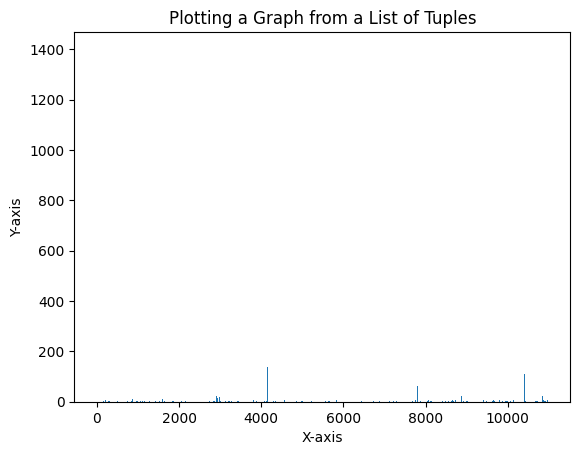

In [134]:
x_coordinates, y_coordinates,_ = zip(*count_to_overlap)

# Plot the graph
plt.bar(x_coordinates, y_coordinates)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plotting a Graph from a List of Tuples')

# Show the plot
plt.show()


[(0, 20, '0xapes-trilogy'), (1, 0, 'orangapes'), (2, 3, 'japanesebornapesociety'), (3, 0, 'tiredapeyachtclub'), (4, 0, 'brokeapeclub-v2-1'), (5, 2, 'solanapesnft'), (6, 83, 'nifty-tailor-genesis'), (7, 0, 'rocknroll-ape-club'), (8, 1, 'mecha-ape-yacht-club'), (9, 0, 'bored-market-ape-club')]
10975


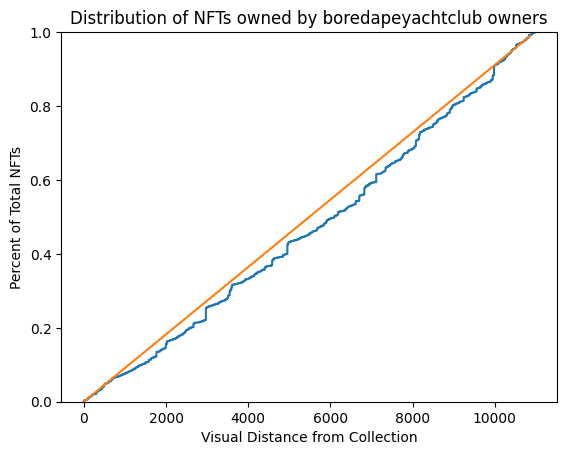

count    29853.000000
mean      5815.097712
std       3152.995330
min          0.000000
0.1%         6.000000
1%         105.000000
10%       1407.000000
25%       2971.000000
50%       6089.000000
75%       8505.000000
max      10973.000000
dtype: float64

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Sample list of tuples (value, count)
# der_list_azuki = ['twintigersjacket','azukielementalschip','beanzofficial','azukielementals','gutter-punks-beanz',
#            'azukigreenbeans','bobutoken','national-beer-day-2022-resonate','azukielementalbeans']
# der_list_alien_fren = ['alien-frens-evolution','alien-frens-incubator','alien-frens-ufos']
# der_list_milady = ['milady-birthday-beach']
der_list_bored = ['otherdeed','mutant-ape-yacht-club']
lander_overlap = [x for x in count_to_overlap2 if x[2] not in der_list_bored]
print(lander_overlap[:10])
# Unpack the tuples into separate lists for values and counts
values, counts,_ = zip(*lander_overlap)
print(values[-1])
# Transform the data to individual values based on counts
individual_values = np.repeat(values, counts)
series = pd.Series(individual_values)

# Create a CDF plot using Seaborn
sns.ecdfplot(data=individual_values)
x = list(np.arange(0,1,0.01))
y = list(np.arange(0,values[-1],values[-1]/100))
# Add labels and title
plt.plot(y,x)
plt.xlabel('Visual Distance from Collection')
plt.ylabel('Percent of Total NFTs')
plt.title(f'Distribution of NFTs owned by {top_slug} owners')

# Show the plot
plt.show()
percentiles = [0.001,0.01,0.1,.25, .5, .75]
series.describe(percentiles=percentiles)

In [225]:
top_slug = 'azuki'
own_slugs = cfu.own_list_from_db(top_slug)
overlap = cfu.count_overlaps(top_slug,pw_dists,own_slugs)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


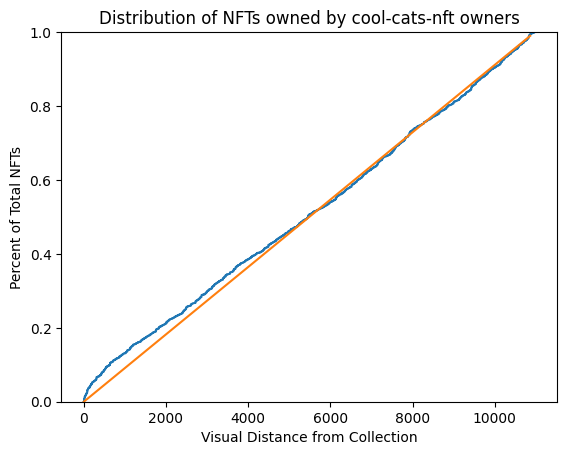

count    59966.000000
mean      5380.467248
std       3335.884075
min          0.000000
0.1%         5.000000
1%          19.000000
10%        634.000000
25%       2476.000000
50%       5460.000000
75%       8228.750000
max      10975.000000
dtype: float64


In [197]:
cfu.make_overlap_cdf(pw_dists,top_slug,der_list = der_list,count_to_overlap=overlap)

In [230]:
sorted_overlap = sorted(overlap,key=lambda x:x[1],reverse=True)
print(sum([x[1] for x in overlap]))
sorted_vis = sorted(overlap,key=lambda x:x[0])
sorted_overlap[:100]
der_list = ['coolpetsnft','shadow-wolves']
sorted_vis[:100]
sum([len(set(x)) for x in own_slugs])

40797


205472

In [218]:
len(imgs.get_immediate_files('counterfeit_images/val/mutantcats'))


276

In [229]:
overlap[1]

(1, 1005, 'azukielementals')

In [233]:
command = "Select distinct slug from owner_lists"
rows = psql.execute_commands([command])
command = "Select distinct slug from overlap_counts"
rows2 = psql.execute_commands([command])
completed_slugs = [x[0] for x in rows]
print(len(completed_slugs))
unfinished_slugs = [x[0] for x in rows2 if x[0] not in completed_slugs]
print(len(unfinished_slugs))
for top_slug in completed_slugs:
    own_slugs = cfu.own_list_from_db(top_slug)
    overlap = cfu.count_overlaps(top_slug,pw_dists,own_slugs)
    overlap_w_slug = [(x[0],x[1],x[2],top_slug) for x in overlap]
    command = "INSERT INTO overlap_counts (distance,overlap, alt,slug) VALUES (%s, %s, %s, %s)"
    psql.batch_insert(command,overlap_w_slug)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000

KeyboardInterrupt: 

In [235]:
del df2

NameError: name 'df2' is not defined